# Exploratory Data Analysis

In [ ]:
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns

from ipyleaflet import Map, SplitMapControl
from localtileserver import TileClient, get_leaflet_tile_layer
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from scipy import stats
from scipy.spatial.distance import cdist

sys.path.insert(0, "..")
from src.data import load_dataset

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

In [2]:
# =============================================================================
# LOAD DATA
# =============================================================================
df, CONFIG = load_dataset("../config/processing.yaml")
info = CONFIG['raster_info']
raster_data = info['data_3d']

# Visualize exported rasters

In [3]:
# Side-by-side visualization of local raster images

def visualize_rasters(left_path, right_path, left_cmap='reds', right_cmap='hot'):
    """Create split-view raster comparison."""
    
    # Create tile clients
    left_client = TileClient(str(left_path))
    right_client = TileClient(str(right_path))
    
    # Create tile layers
    left_layer = get_leaflet_tile_layer(left_client, colormap=left_cmap)
    right_layer = get_leaflet_tile_layer(right_client, colormap=right_cmap)
    
    # Create map
    m = Map(center=[12.37, -1.53], zoom=11)
    
    # Add split control
    control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
    m.add_control(control)
    
    return m

left_layer = CONFIG['data_dir'] / 'ouaga_BSI.tif'
right_layer = CONFIG['data_dir'] / 'ouaga_NDBI.tif'
m = visualize_rasters(
    left_layer,
    right_layer,
    left_cmap="blues",
    right_cmap='blues'
)
m

Map(center=[12.37, -1.53], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [4]:
# Side-by-side visualization using the stacked raster

stacked_path = CONFIG['data_dir'] / 'ouaga_aligned_stack.tif'

client = TileClient(str(stacked_path))

left_layer = get_leaflet_tile_layer(client, band=CONFIG['band_index']['BSI'], colormap='blues')
right_layer = get_leaflet_tile_layer(client, band=CONFIG['band_index']['NDBI'], colormap='blues')

m = Map(center=[12.37, -1.53], zoom=11)
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)
m

Map(center=[12.37, -1.53], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

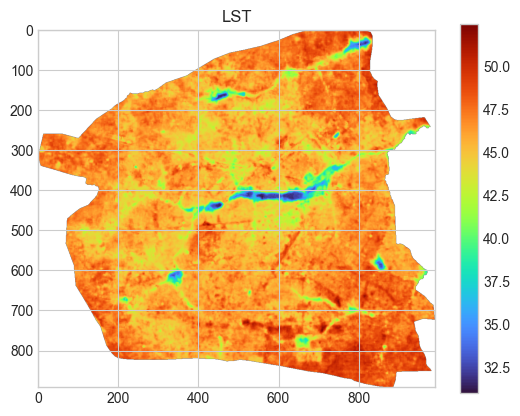

In [5]:
with rasterio.open(CONFIG['raster_path']) as src:
    data = src.read(CONFIG['band_index']['LST'])

fig, ax = plt.subplots()
im = ax.imshow(data, cmap='turbo')
fig.colorbar(im)
ax.set_title('LST')
plt.show()

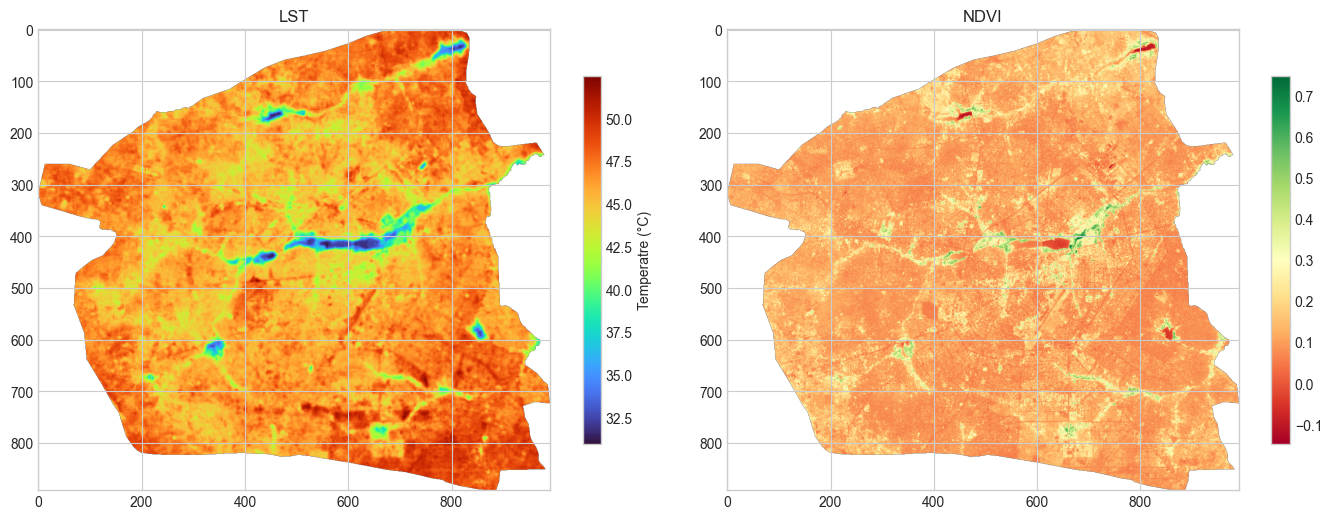

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))                                             
                                                                                                    
with rasterio.open(CONFIG['raster_path']) as src:                                                 
    im1 = ax1.imshow(src.read(CONFIG['band_index']['LST']), cmap='turbo')              
    ax1.set_title('LST')                                                                          
    fig.colorbar(im1, ax=ax1, label='Temperatre (°C)', shrink=0.8)                                             

    im2 = ax2.imshow(src.read(CONFIG['band_index']['NDVI']), cmap='RdYlGn')
    ax2.set_title('NDVI')
    fig.colorbar(im2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()

# Exploratory Data Analysis (EDA) and Validation

In [7]:
# =============================================================================
# SECTION 1: DATA OVERVIEW
# =============================================================================

print(f"Raster shape: {info['shape']} (bands, rows, cols)")
print(f"CRS: {info['crs']}")
print(f"Resolution: {info['resolution'][0]:.1f}m x {info['resolution'][1]:.1f}m")
print(f"Bounds: {info['bounds']}")

if info['band_names_match'] is None:
    print(f"  No band descriptions in file, trusting band_names from config")
elif info['band_names_match']:
    print(f"Band descriptions: {info['band_names']} (matches expected)")
else:
    print(f"  WARNING: Band descriptions in file don't match expected band_names!")
    print(f"  File has:  {info['file_band_names']}")
    print(f"  Expected:  {CONFIG['band_names']}")
    print(f"  Using file descriptions as source of truth.")

print(f"Valid pixels: {info['n_valid']:,} / {info['n_total']:,} ({info['coverage_pct']:.1f}%)")
print(f"\nLoaded {len(df):,} pixels into DataFrame")
print(f"  Columns: {list(df.columns)}")

Raster shape: (10, 892, 991) (bands, rows, cols)
CRS: EPSG:32630
Resolution: 30.0m x 30.0m
Bounds: BoundingBox(left=642990.0, bottom=1355700.0, right=672720.0, top=1382460.0)
Band descriptions: ['NDVI', 'NDBI', 'BSI', 'DEM', 'distance_to_water', 'distance_to_roads', 'built_density', 'green_density', 'LST', 'hotspot'] (matches expected)
Valid pixels: 613,847 / 883,972 (69.4%)

Loaded 613,847 pixels into DataFrame
  Columns: ['row', 'col', 'lon', 'lat', 'NDVI', 'NDBI', 'BSI', 'DEM', 'distance_to_water', 'distance_to_roads', 'built_density', 'green_density', 'LST', 'hotspot']


In [8]:
df

row  col       lon        lat      NDVI      NDBI       BSI  \
0         1  711  664335.0  1382415.0  0.228656  0.157543  0.220852   
1         1  712  664365.0  1382415.0  0.156717  0.165503  0.220143   
2         1  713  664395.0  1382415.0  0.162594  0.176038  0.228319   
3         1  714  664425.0  1382415.0  0.156953  0.163224  0.220589   
4         1  715  664455.0  1382415.0  0.157885  0.182193  0.230280   
...     ...  ...       ...        ...       ...       ...       ...   
613842  891  882  669465.0  1355715.0  0.106598  0.225091  0.289564   
613843  891  883  669495.0  1355715.0  0.101580  0.231169  0.297806   
613844  891  884  669525.0  1355715.0  0.107755  0.192365  0.269316   
613845  891  885  669555.0  1355715.0  0.111385  0.224868  0.290137   
613846  891  886  669585.0  1355715.0  0.068804  0.175018  0.269254   

               DEM  distance_to_water  distance_to_roads  built_density  \
0       297.094330        2683.281494          67.082039       0.000000   
1       296.672546        2656.482666          84.852814       0.000000   
2       296.131134        2629.752930         108.166542       0.000000   
3       296.192596        2603.094238         127.279221       0.000000   
4       296.193451        2576.509277         150.000000       0.000000   
...            ...                ...                ...            ...   
613842  312.088989        5219.051758          30.000000       0.000000   
613843  312.301453        5192.166992           0.000000       0.000000   
613844  312.513153        5165.316895          30.000000       0.103448   
613845  312.597137        5138.501953           0.000000       0.172414   
613846  312.832550        5111.721680           0.000000       0.206897   

        green_density        LST  hotspot  
0            0.310345  47.472202      0.0  
1            0.379310  47.451694      0.0  
2            0.413793  47.441441      0.0  
3            0.344828  47.451694      0.0  
4            0.241379  47.523472      0.0  
...               ...        ...      ...  
613842       0.000000  48.583057      1.0  
613843       0.000000  48.429249      1.0  
613844       0.000000  48.313034      1.0  
613845       0.000000  48.015667      0.0  
613846       0.000000  47.837929      0.0  

[613847 rows x 14 columns]

In [9]:
# =============================================================================
# SECTION 2: DATA VALIDATION
# =============================================================================
print("\n" + "=" * 80)
print("SECTION 2: DATA VALIDATION")
print("=" * 80)

def validate_data(df, expected_ranges, band_names):
    """
    Comprehensive data validation with range checks and outlier detection.
    """
    validation_results = {}
    
    predictor_cols = [c for c in band_names if c != 'hotspot']
    
    print("\n--- Missing Values ---")
    missing = df[band_names].isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values ✓")
    
    print("\n--- Value Range Validation ---")
    for col in band_names:
        if col in expected_ranges:
            exp_min, exp_max = expected_ranges[col]
            actual_min, actual_max = df[col].min(), df[col].max()
            
            in_range = (actual_min >= exp_min * 0.9) and (actual_max <= exp_max * 1.1)
            status = "✓" if in_range else "⚠️ OUT OF RANGE"
            
            print(f"  {col:.<25} Expected: [{exp_min:>8.2f}, {exp_max:>8.2f}] | "
                  f"Actual: [{actual_min:>8.2f}, {actual_max:>8.2f}] {status}")
            
            validation_results[col] = {
                'expected_range': (exp_min, exp_max),
                'actual_range': (actual_min, actual_max),
                'valid': in_range
            }
    
    print("\n--- LST Sanity Check (Ouagadougou Hot Season) ---")
    lst_mean = df['LST'].mean()
    lst_std = df['LST'].std()
    print(f"  Mean LST: {lst_mean:.1f}°C (expected: 40-50°C for March-May)")
    print(f"  Std LST: {lst_std:.1f}°C")
    print(f"  Range: {df['LST'].min():.1f}°C - {df['LST'].max():.1f}°C")
    
    if lst_mean < 35 or lst_mean > 55:
        print("  ⚠️ WARNING: LST mean seems unusual for Ouagadougou hot season!")
    else:
        print("  ✓ LST values appear reasonable")
    
    print("\n--- Hotspot Class Balance ---")
    hotspot_counts = df['hotspot'].value_counts()
    total = len(df)
    print(f"  Non-hotspot (0): {hotspot_counts.get(0, 0):>10,} ({100*hotspot_counts.get(0, 0)/total:.1f}%)")
    print(f"  Hotspot (1):     {hotspot_counts.get(1, 0):>10,} ({100*hotspot_counts.get(1, 0)/total:.1f}%)")
    
    imbalance_ratio = hotspot_counts.get(0, 1) / max(hotspot_counts.get(1, 1), 1)
    if imbalance_ratio > 10:
        print(f"  ⚠️ High class imbalance ({imbalance_ratio:.1f}:1) - consider stratification")
    
    return validation_results

validation_results = validate_data(df, CONFIG['expected_ranges'], CONFIG['band_names'])


SECTION 2: DATA VALIDATION

--- Missing Values ---
No missing values ✓

--- Value Range Validation ---
  NDVI..................... Expected: [   -1.00,     1.00] | Actual: [   -0.15,     0.75] ✓
  NDBI..................... Expected: [   -1.00,     1.00] | Actual: [   -0.33,     0.35] ✓
  BSI...................... Expected: [   -1.00,     1.00] | Actual: [   -0.26,     0.39] ✓
  DEM...................... Expected: [  200.00,   400.00] | Actual: [  273.92,   347.02] ✓
  distance_to_water........ Expected: [    0.00, 30000.00] | Actual: [    0.00, 13606.41] ✓
  distance_to_roads........ Expected: [    0.00, 10000.00] | Actual: [    0.00,   657.95] ✓
  built_density............ Expected: [    0.00,     1.00] | Actual: [    0.00,     1.00] ✓
  green_density............ Expected: [    0.00,     1.00] | Actual: [    0.00,     1.00] ✓
  LST...................... Expected: [   25.00,    60.00] | Actual: [   30.95,    52.50] ✓
  hotspot.................. Expected: [    0.00,     1.00] | Actual:

In [10]:
# =============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("SECTION 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

predictor_cols = [c for c in CONFIG['band_names'] if c not in ['hotspot', 'LST']]

# --- 3.1: Summary Statistics ---
print("\n--- Summary Statistics ---")
summary_stats = df[CONFIG['band_names']].describe().T
summary_stats['skewness'] = df[CONFIG['band_names']].skew()
summary_stats['kurtosis'] = df[CONFIG['band_names']].kurtosis()
print(summary_stats.round(3))

# Save to CSV
summary_stats.to_csv(CONFIG['figures_dir'] / 'summary_statistics.csv')
print(f"\n✓ Saved summary statistics to {CONFIG['figures_dir'] / 'summary_statistics.csv'}")


SECTION 3: EXPLORATORY DATA ANALYSIS

--- Summary Statistics ---
                      count      mean       std      min       25%       50%  \
NDVI               613847.0     0.130     0.070   -0.148     0.086     0.111   
NDBI               613847.0     0.150     0.054   -0.334     0.130     0.158   
BSI                613847.0     0.224     0.045   -0.264     0.210     0.230   
DEM                613847.0   305.257    11.333  273.918   297.035   304.740   
distance_to_water  613847.0  4146.202  2273.603    0.000  2448.448  3987.292   
distance_to_roads  613847.0    35.334    51.657    0.000     0.000    30.000   
built_density      613847.0     0.529     0.417    0.000     0.034     0.621   
green_density      613847.0     0.109     0.221    0.000     0.000     0.000   
LST                613847.0    45.998     2.094   30.953    45.171    46.190   
hotspot            613847.0     0.103     0.304    0.000     0.000     0.000   

                        75%        max  skewness  kur

In [11]:
# --- 3.2: Statistical Tests (Hotspot vs Non-Hotspot) ---
print("\n--- Statistical Tests: Hotspot vs Non-Hotspot ---")

hotspot_df = df[df['hotspot'] == 1]
non_hotspot_df = df[df['hotspot'] == 0]

print(f"\n{'Variable':<25} {'Non-Hotspot Mean':>18} {'Hotspot Mean':>15} {'Diff':>10} {'t-stat':>10} {'p-value':>12}")
print("-" * 95)

test_results = []
for col in predictor_cols:
    mean_non = non_hotspot_df[col].mean()
    mean_hot = hotspot_df[col].mean()
    diff = mean_hot - mean_non
    
    # Welch's t-test (doesn't assume equal variances)
    t_stat, p_val = stats.ttest_ind(
        hotspot_df[col].dropna(), 
        non_hotspot_df[col].dropna(), 
        equal_var=False
    )
    
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    
    print(f"{col:<25} {mean_non:>18.4f} {mean_hot:>15.4f} {diff:>+10.4f} {t_stat:>10.2f} {p_val:>10.2e} {sig}")
    
    test_results.append({
        'variable': col,
        'mean_non_hotspot': mean_non,
        'mean_hotspot': mean_hot,
        'difference': diff,
        't_statistic': t_stat,
        'p_value': p_val,
        'significant': p_val < 0.05
    })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(CONFIG['figures_dir'] / 'ttest_results.csv', index=False)
print(f"\n✓ Saved t-test results")


--- Statistical Tests: Hotspot vs Non-Hotspot ---

Variable                    Non-Hotspot Mean    Hotspot Mean       Diff     t-stat      p-value
-----------------------------------------------------------------------------------------------
NDVI                                  0.1306          0.1230    -0.0076     -39.54   0.00e+00 ***
NDBI                                  0.1454          0.1873    +0.0420     270.27   0.00e+00 ***
BSI                                   0.2206          0.2537    +0.0331     229.61   0.00e+00 ***
DEM                                 304.9955        307.5300    +2.5345      51.30   0.00e+00 ***
distance_to_water                  4043.4377       5039.7681  +996.3303     105.19   0.00e+00 ***
distance_to_roads                    33.3898         52.2437   +18.8539      73.89   0.00e+00 ***
built_density                         0.5704          0.1680    -0.4025    -329.39   0.00e+00 ***
green_density                         0.1066          0.1313    +0.024

--- Generating Spatial Distribution Maps ---


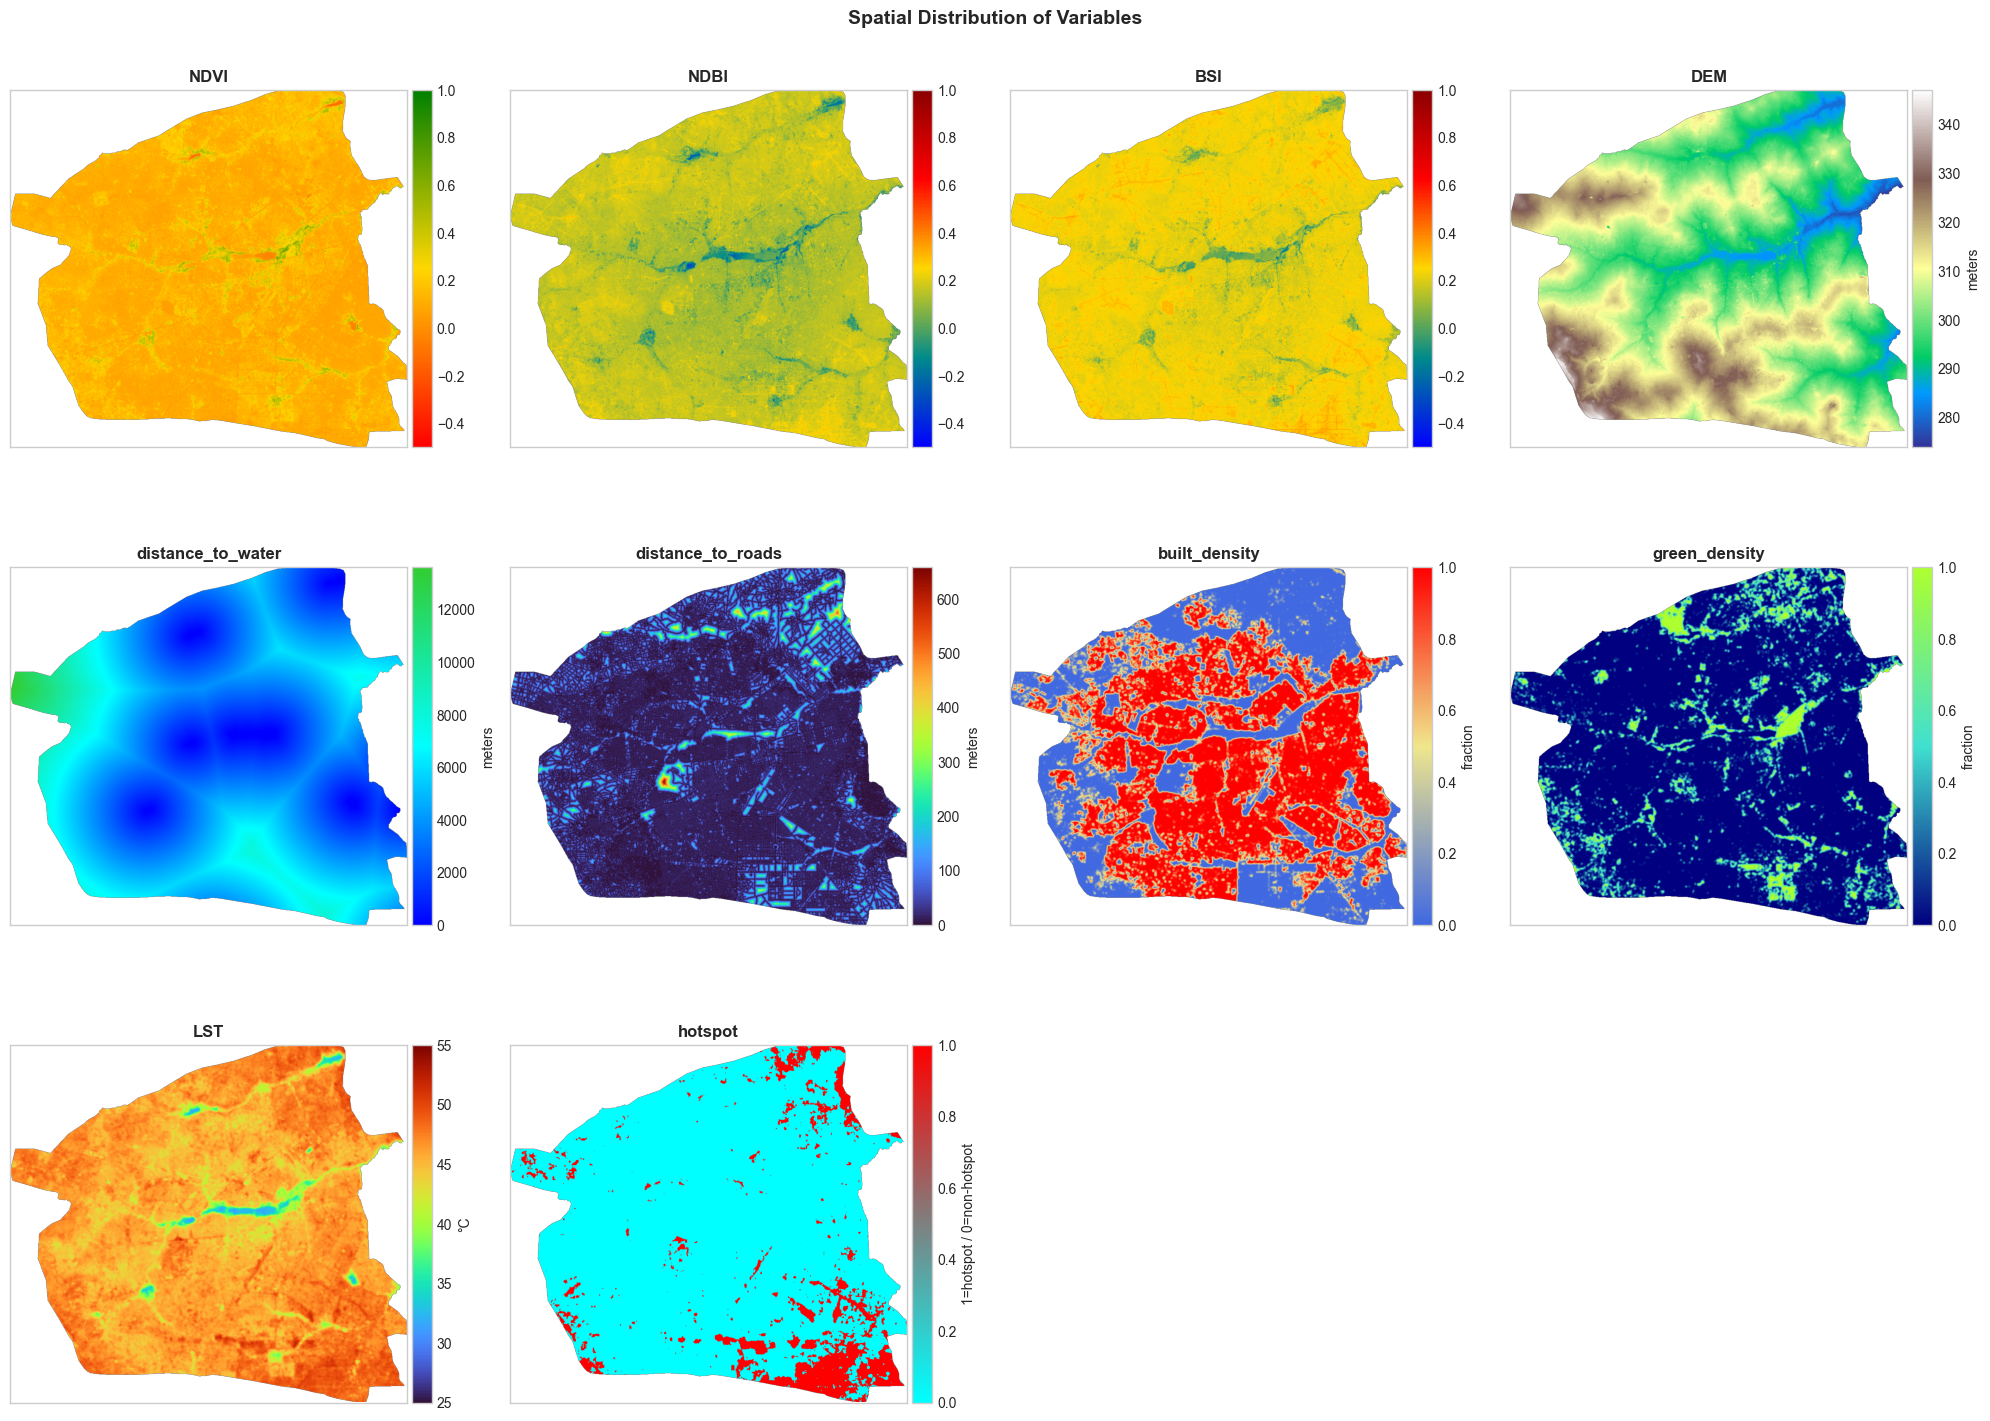

✓ Saved spatial distribution maps


In [12]:
# --- 3.3: Spatial Distribution Maps ---
print("--- Generating Spatial Distribution Maps ---")

# Custom colormaps (matching the GEE visualization palettes)
cmap_ndvi = LinearSegmentedColormap.from_list('ndvi', ['red', 'gold', 'green'])
cmap_ndbi_bsi = LinearSegmentedColormap.from_list('ndbi_bsi', ['blue', 'darkcyan', 'gold', 'red', 'darkred'])
cmap_dist_water = LinearSegmentedColormap.from_list('dist_water', ['blue', 'cyan', 'limegreen'])
cmap_built = LinearSegmentedColormap.from_list('built', ['royalblue', 'khaki', 'red'])
cmap_green = LinearSegmentedColormap.from_list('green', ['navy', 'turquoise', 'greenyellow'])
cmap_hotspot = LinearSegmentedColormap.from_list('hotspot', ['cyan', 'red'])

# Visualization config: (colormap, vmin, vmax) - matching the GEE vis parameters
spatial_vis = {
    'NDVI':              (cmap_ndvi,       -0.5, 1),
    # 'NDVI':              ('RdYlGn',       -0.5, 1),
    'NDBI':              (cmap_ndbi_bsi,   -0.5, 1),
    'BSI':               (cmap_ndbi_bsi,   -0.5, 1),
    'DEM':               ('terrain',        None, None),  # Auto scale for elevation
    'distance_to_water': (cmap_dist_water,    None, None),  # Auto scale for distance
    'distance_to_roads': ('turbo',            None, None),  # Auto scale for distance
    'built_density':     (cmap_built,         0, 1),
    'green_density':     (cmap_green,         0, 1),
    'LST':               ('turbo',         25, 55),
    'hotspot':           (cmap_hotspot,       0, 1),
}

n_bands = len(CONFIG['band_names'])
ncols = 4
nrows = (n_bands + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(CONFIG['band_names']):
    ax = axes[i]
    band_idx = CONFIG['band_index'][col] - 1  # Convert 1-indexed to 0-indexed
    band_data = np.ma.masked_invalid(raster_data[band_idx])

    cmap, vmin, vmax = spatial_vis[col]

    im = ax.imshow(band_data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

    # Colorbar sized to match the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if col == 'LST':
        fig.colorbar(im, label='°C', cax=cax)
    elif col == 'hotspot':
        fig.colorbar(im, label='1=hotspot / 0=non-hotspot', cax=cax)
    elif col == 'DEM' or col.startswith('distance'):
        fig.colorbar(im, label='meters', cax=cax)
    elif col.endswith('density'):
        fig.colorbar(im, label='fraction', cax=cax)
    else:
        fig.colorbar(im, cax=cax)

# Hide empty subplots
for j in range(n_bands, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Spatial Distribution of Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['figures_dir'] / 'spatial_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved spatial distribution maps")


--- Generating Distribution Plots ---


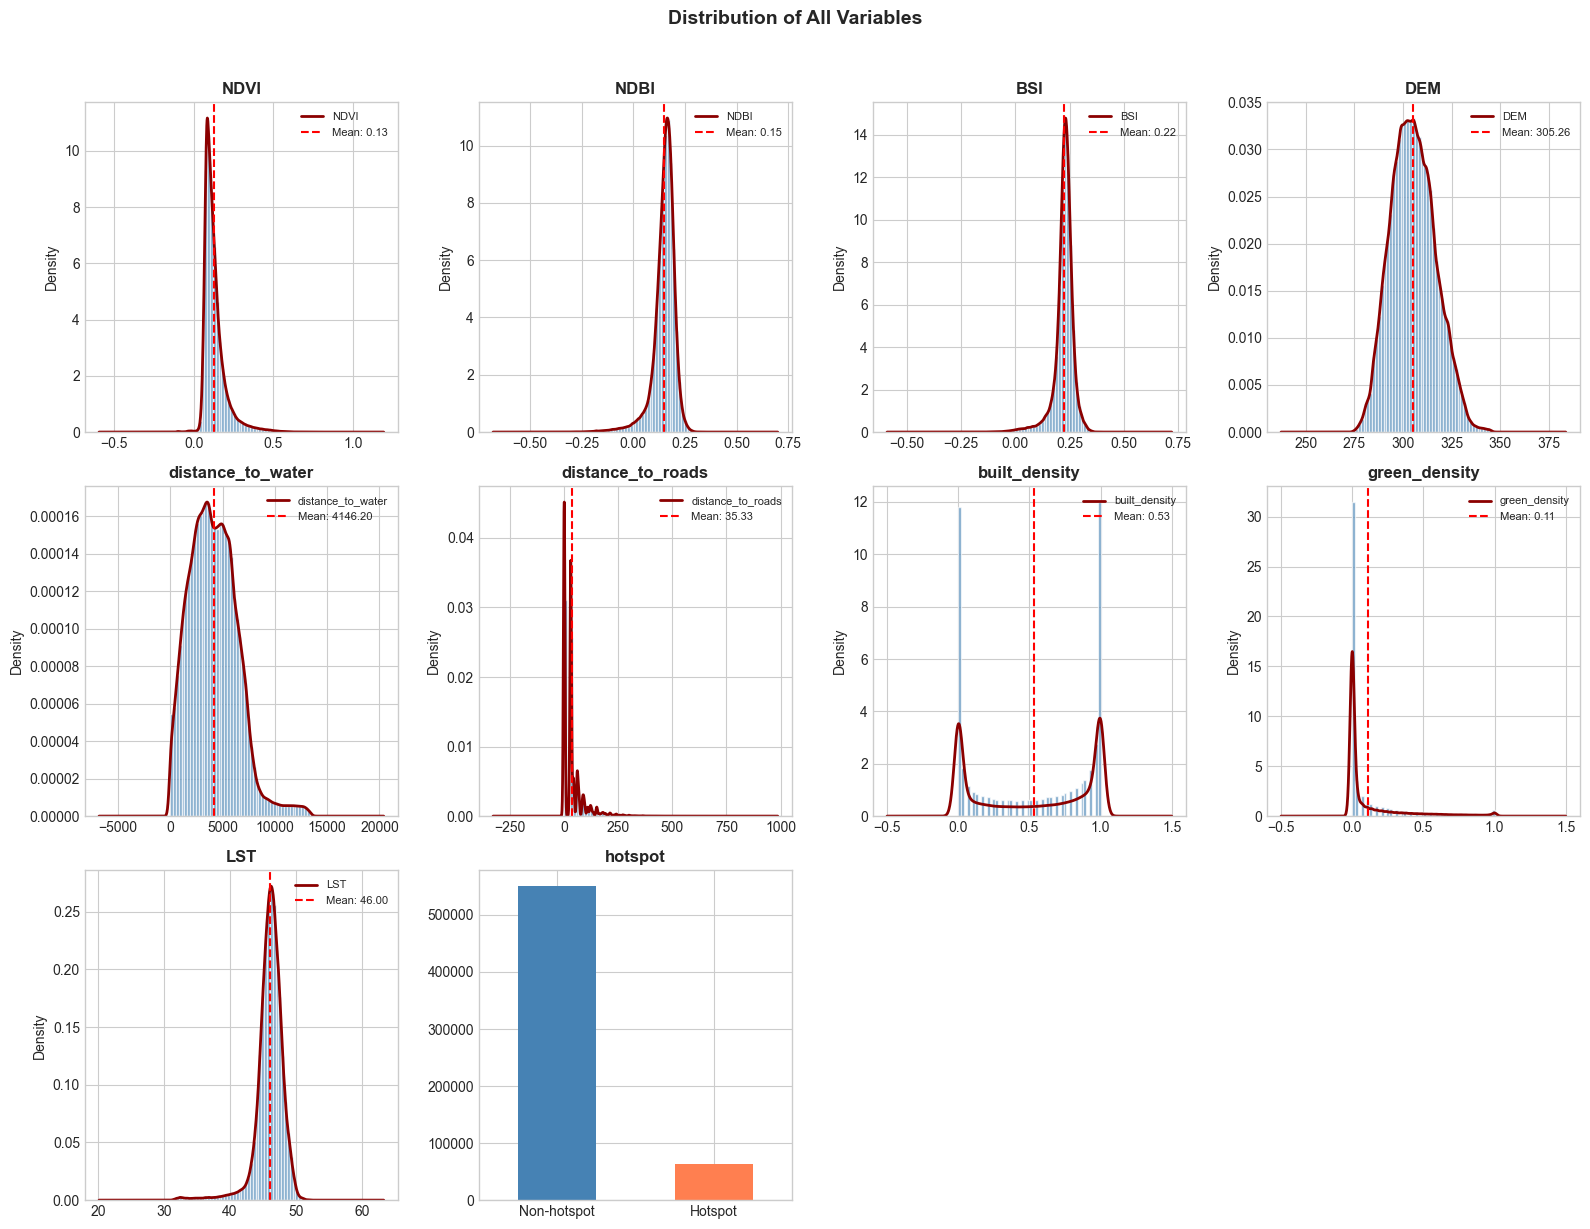

✓ Saved distribution plots


In [13]:
# --- 3.4: Distribution Plots ---
print("\n--- Generating Distribution Plots ---")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(CONFIG['band_names']):
    ax = axes[i]
    
    # Histogram with KDE
    data_col = df[col].dropna()
    
    if col == 'hotspot':
        # Bar plot for binary
        df[col].value_counts().plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
        ax.set_xticklabels(['Non-hotspot', 'Hotspot'], rotation=0)
    else:
        ax.hist(data_col, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
        
        # Add KDE
        if len(data_col) > 100:
            data_col.plot.kde(ax=ax, color='darkred', linewidth=2)
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    
    # Add mean line for continuous variables
    if col != 'hotspot':
        ax.axvline(data_col.mean(), color='red', linestyle='--', linewidth=1.5, 
                   label=f'Mean: {data_col.mean():.2f}')
        ax.legend(fontsize=8)

# Hide empty subplots
for j in range(len(CONFIG['band_names']), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution of All Variables', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(CONFIG['figures_dir'] / 'distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved distribution plots")

--- Generating Box Plots by Hotspot Status ---


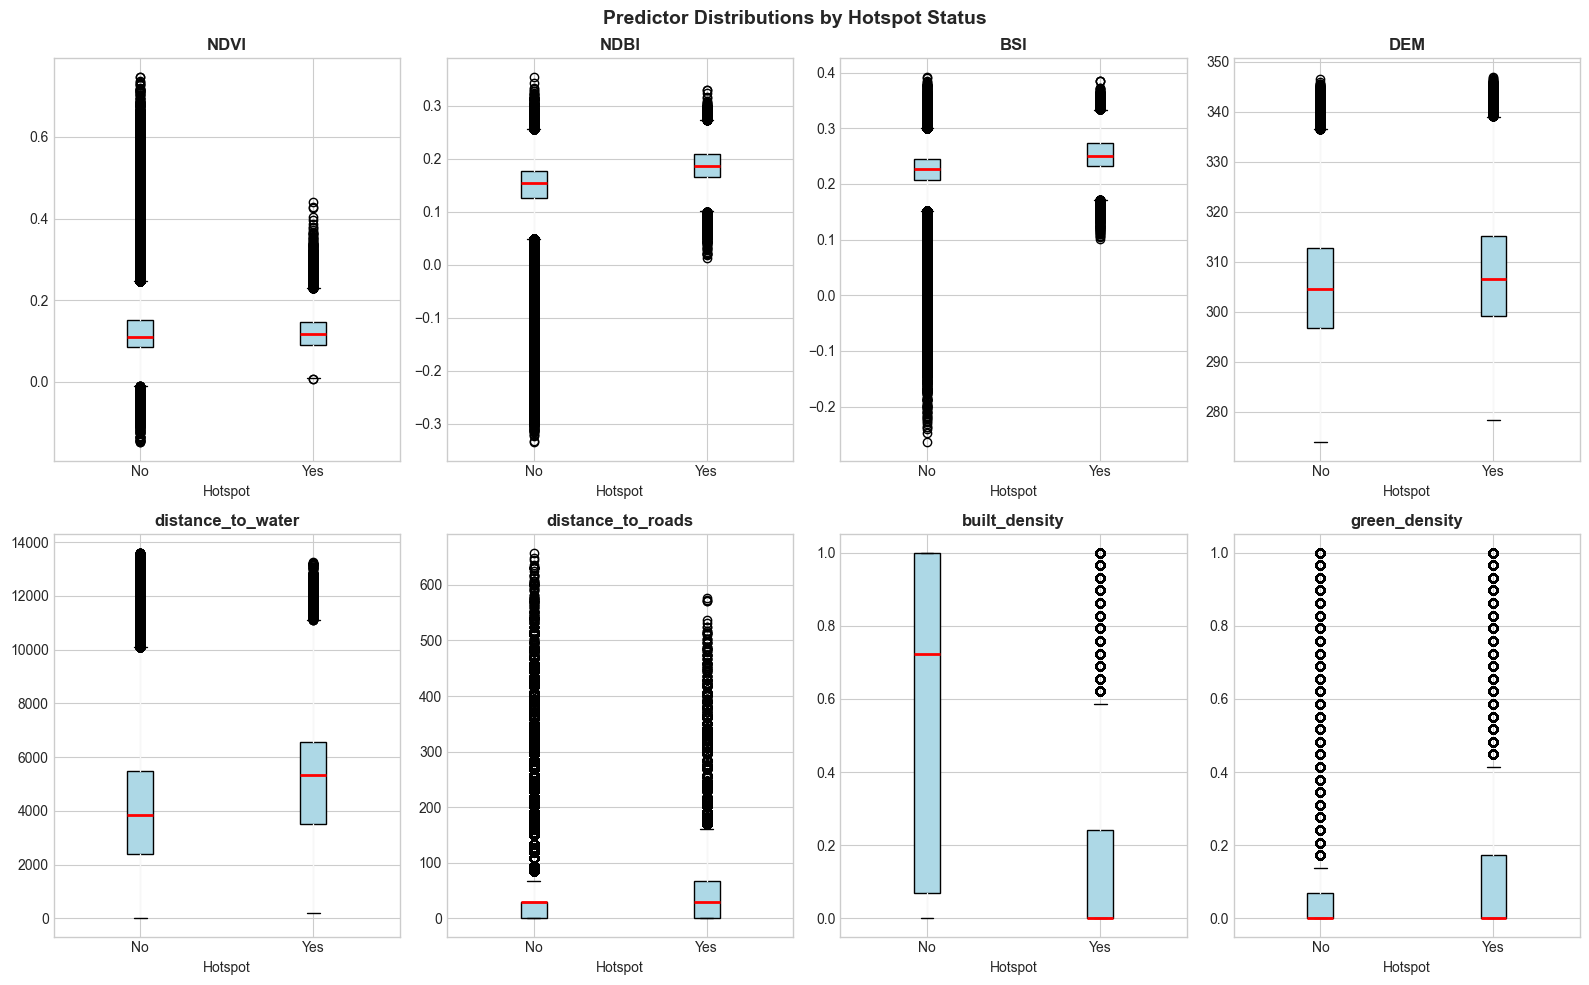

✓ Saved box plots


In [14]:
# --- 3.5: Box Plots by Hotspot Status ---
print("--- Generating Box Plots by Hotspot Status ---")

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(predictor_cols):
    ax = axes[i]
    
    df.boxplot(column=col, by='hotspot', ax=ax, 
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
    
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_xlabel('Hotspot')
    ax.set_xticklabels(['No', 'Yes'])

# Hide empty subplots
for j in range(len(predictor_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Predictor Distributions by Hotspot Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['figures_dir'] / 'boxplots_by_hotspot.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved box plots")

Bare Soil Index (BSI) and Normalized Difference Built-up Index (NDBI) look similar because they're measuring spectrally similar things, especially in a semi-arid city like Ouagadougou:

1. Formula overlap
- NDBI = (SWIR - NIR) / (SWIR + NIR)
- BSI = ((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))

Both rely heavily on the SWIR-NIR contrast, which is the main driver of the signal.

2. Spectral overlap in dryland cities

In Ouagadougou:
- Buildings are often made of local materials (bricks, laterite) that spectrally resemble bare soil
- Unpaved roads and bare ground dominate between structures
- There's no clear spectral boundary between "built" and "bare soil"

In a European or North American city, NDBI would pick up concrete/asphalt distinctly from bare earth. In the Sahel, they blend together.

**A note on distribution shapes and outlier detection:**

The observed distributions are consistent with what we'd expect for a semi-arid Sahelian city. Most of Ouagadougou is bare soil or low-rise built environment made from local materials (laterite, brick), so the spectral indices (NDVI, NDBI, BSI) are tightly concentrated in a narrow range - the landscape is spectrally homogeneous. The few vegetated pixels (parks, reservoir edges) create a small tail of higher NDVI values, but these are real and not measurement errors.

Built density is bimodal, clustering at 0 and 1. This is expected: we compute both density measures with a 90m kernel over a binary land cover mask, so pixels in the dense urban core have nearly all built-up neighbors (~1) and pixels in the outskirts have none (~0). Only the narrow transition zones between urban and non-urban produce intermediate values.

Distance to roads is heavily right-skewed because the road network is dense - most pixels are within a few hundred meters of a road, and the maximum is only ~660m. Distance to water skews the other way: there are few water bodies, so most of the city is several kilometers from water, with a tail toward zero near the reservoirs.

DEM is tightly distributed (273-347m, only ~70m of relief) because Ouagadougou is flat. LST is similarly concentrated during the hot season because the whole city is hot; the spread is mainly driven by vegetation and bare soil contrasts.

In [15]:
# =============================================================================
# SECTION 4: CORRELATION ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("SECTION 4: CORRELATION ANALYSIS")
print("=" * 80)

# --- 4.1: Pearson Correlation Matrix ---
print("\n--- Pearson Correlation Matrix ---")

# Include LST but not hotspot (it's derived from LST)
corr_cols = predictor_cols + ['LST']
corr_matrix = df[corr_cols].corr(method='pearson')

print("\nCorrelations with LST:")
lst_corr = corr_matrix['LST'].drop('LST').sort_values(key=abs, ascending=False)
for var, corr in lst_corr.items():
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    print(f"  {var:.<30} r = {corr:>+.3f} ({strength})")

# --- 4.2: Spearman Correlation (for non-linear relationships) ---
print("\n--- Spearman Correlation (rank-based, captures non-linear) ---")

spearman_corr = df[corr_cols].corr(method='spearman')

print("\nSpearman Correlations with LST:")
lst_spearman = spearman_corr['LST'].drop('LST').sort_values(key=abs, ascending=False)
for var, corr in lst_spearman.items():
    pearson_r = corr_matrix.loc[var, 'LST']
    diff = corr - pearson_r
    flag = " (non-linear?)" if abs(diff) > 0.05 else ""
    print(f"  {var:.<30} ρ = {corr:>+.3f} (Pearson: {pearson_r:>+.3f}){flag}")


SECTION 4: CORRELATION ANALYSIS

--- Pearson Correlation Matrix ---

Correlations with LST:
  BSI........................... r = +0.660 (strong)
  NDBI.......................... r = +0.659 (strong)
  distance_to_water............. r = +0.337 (moderate)
  DEM........................... r = +0.316 (moderate)
  NDVI.......................... r = -0.310 (moderate)
  green_density................. r = -0.206 (weak)
  distance_to_roads............. r = -0.105 (weak)
  built_density................. r = -0.103 (weak)

--- Spearman Correlation (rank-based, captures non-linear) ---

Spearman Correlations with LST:
  BSI........................... ρ = +0.475 (Pearson: +0.660) (non-linear?)
  NDBI.......................... ρ = +0.461 (Pearson: +0.659) (non-linear?)
  distance_to_water............. ρ = +0.299 (Pearson: +0.337)
  built_density................. ρ = -0.293 (Pearson: -0.103) (non-linear?)
  DEM........................... ρ = +0.246 (Pearson: +0.316) (non-linear?)
  distance_to_roads.

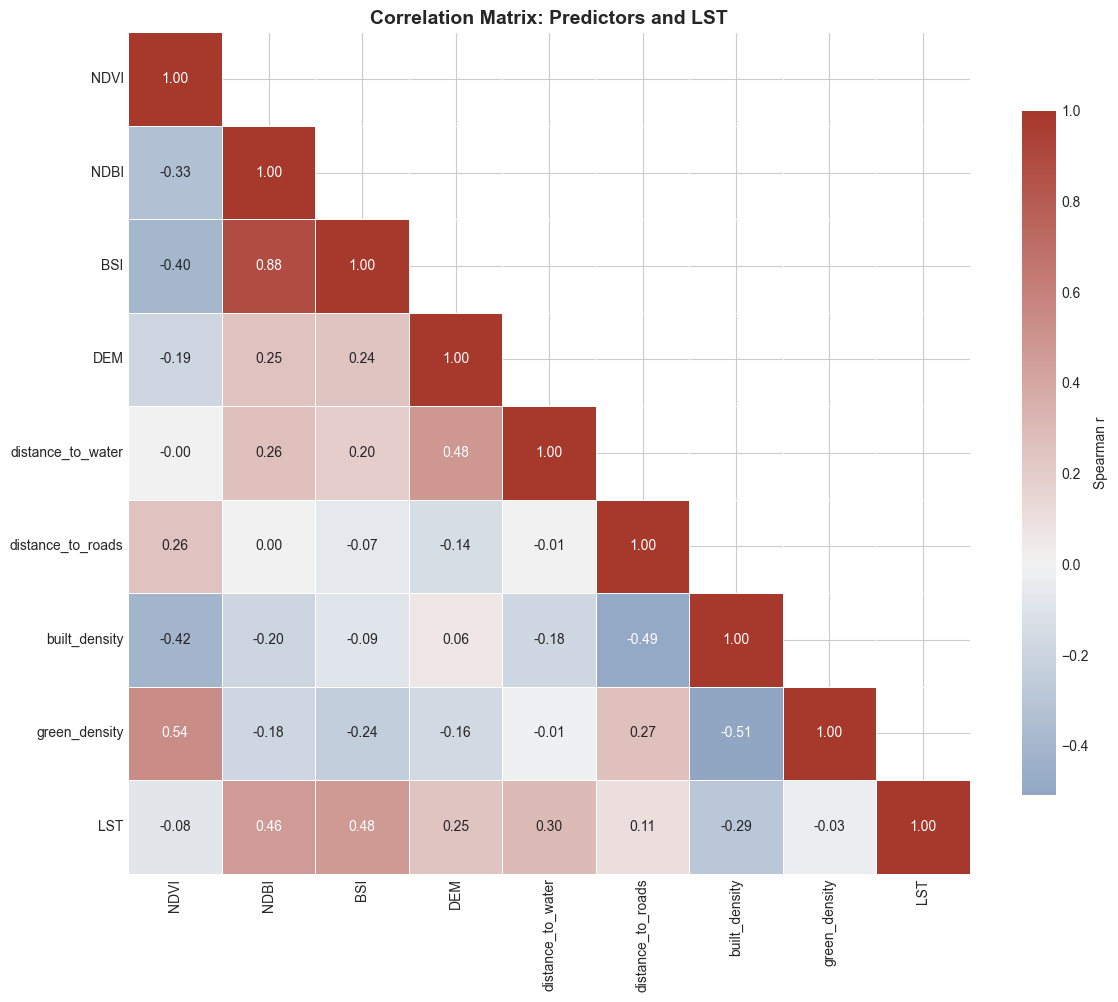

✓ Saved correlation heatmap


In [16]:
# --- 4.3: Correlation Heatmap ---
fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(spearman_corr, dtype=bool), k=1)
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center='light', as_cmap=True)

sns.heatmap(spearman_corr, mask=mask, cmap=cmap, center=0,
            annot=True, fmt='.2f', square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Spearman r'},
            ax=ax)

ax.set_title('Correlation Matrix: Predictors and LST', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['figures_dir'] / 'correlation_spearman_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved correlation heatmap")


--- Generating Scatter Plots for Key Relationships ---


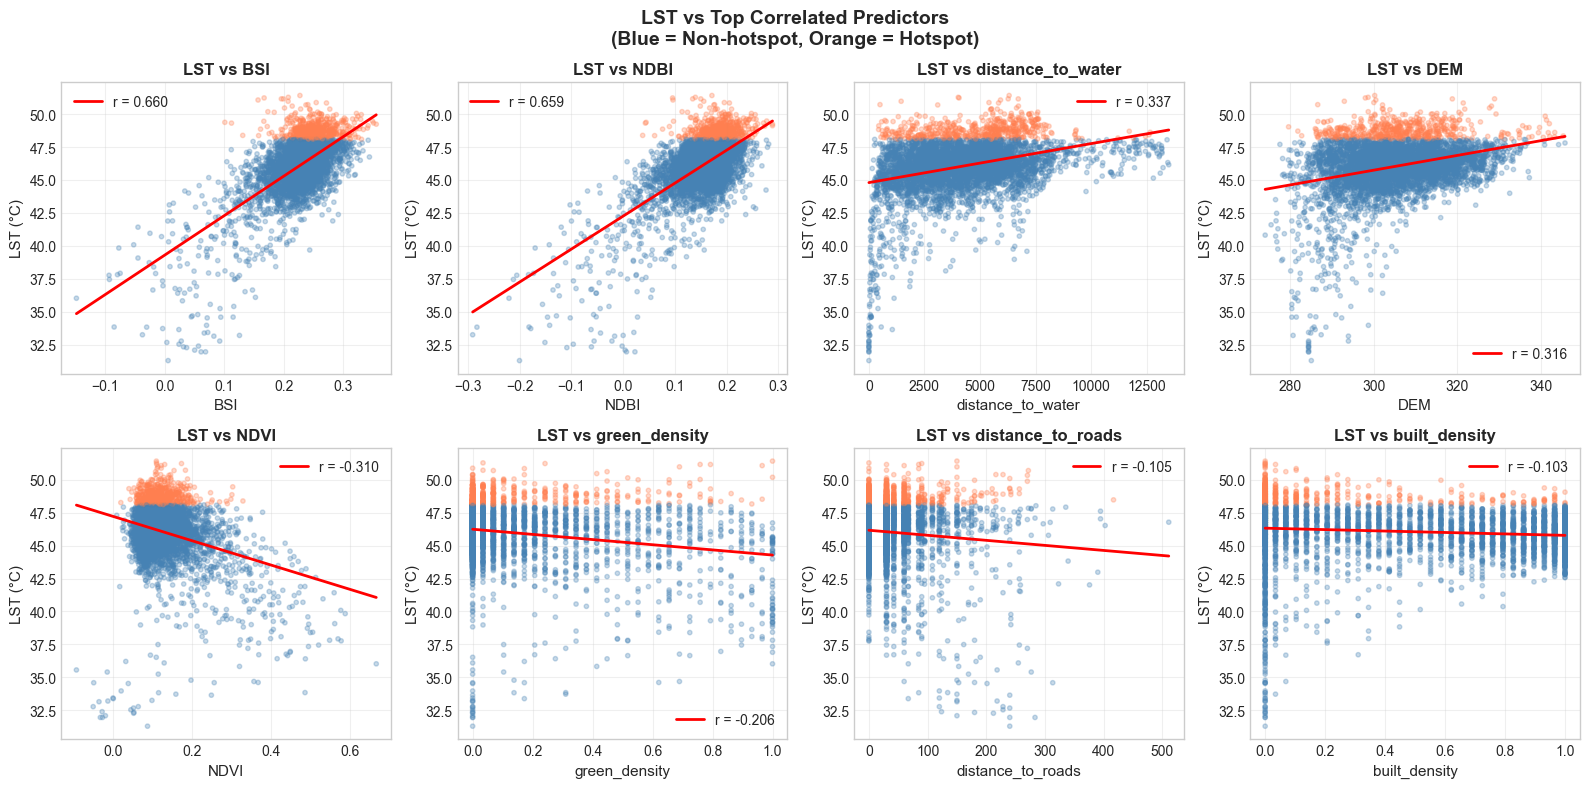

✓ Saved scatter plots


In [17]:
# --- 4.4: Pairwise Scatter Plots (Key Relationships) ---
print("\n--- Generating Scatter Plots for Key Relationships ---")

# Top 8 correlated predictors with LST
top_predictors = lst_corr.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, pred in enumerate(top_predictors):
    ax = axes[i]
    
    # Sample for plotting
    sample = df.sample(n=min(5000, len(df)), random_state=42)
    
    # Scatter with hotspot coloring
    colors = sample['hotspot'].map({0: 'steelblue', 1: 'coral'})
    ax.scatter(sample[pred], sample['LST'], c=colors, alpha=0.3, s=10)
    
    # Add regression line
    z = np.polyfit(sample[pred], sample['LST'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample[pred].min(), sample[pred].max(), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'r = {corr_matrix.loc[pred, "LST"]:.3f}')
    
    ax.set_xlabel(pred, fontsize=11)
    ax.set_ylabel('LST (°C)', fontsize=11)
    ax.set_title(f'LST vs {pred}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('LST vs Top Correlated Predictors\n(Blue = Non-hotspot, Orange = Hotspot)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['figures_dir'] / 'scatter_lst_predictors.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved scatter plots")

BSI & NDBI = Clear linear trends, and they look nearly identical. Reinforces that they might be capturing the same thing (cause of spectral overlap of built structure materials and bare soil).

NDVI =  The bulk of the data is clustered at low NDVI (0-0.2) with almost no relationship to LST within that cluster. The Pearson r of -0.31 is being pulled by the sparse tail of vegetated pixels out to 0.6+. That's why Spearman dropped to -0.08. It seems for most of the city, NDVI doesn't discriminate LST well because there's so little of it. With more sample points of actually vegetated areas, a stronger relationship might be visible. At the moment, the relationship seems to be driven mainly by the few "outlier" data points with higher NDVI (0.4+).

green_density & built_density = The vertical striping shows the bimodal nature (values clustering at 0 and 1 from the binary land cover kernel). A linear fit through bimodal data is basically
meaningless. These are really two groups, not a continuous gradient. That's why Spearman and Pearson disagree so much. A threshold/categorical treatment would capture these better.

distance_to_roads = Nearly all pixels are within 0-100m, with a flat blob. There's no clear trend in either direction, which matches both correlations being near zero (opposite signs). The road network is too dense for distance to be informative.

Takeaway for modeling: The plots make a strong visual case that the relationships aren't linear, the data is clustered, and a tree-based model would handle all of this naturally (the bimodal
densities, the NDVI threshold effect, the non-linear distance relationships) without needing to engineer any of it manually.

In [18]:
# =============================================================================
# SECTION 5: SPATIAL AUTOCORRELATION CHECK
# =============================================================================

def compute_semivariogram(df, variable, n_bins=20, max_dist=None, sample_size=3000):
    """
    Compute empirical semivariogram to assess spatial autocorrelation.
    
    The semivariogram shows how variance changes with distance.
    - Flat line = no spatial autocorrelation
    - Increasing curve = positive spatial autocorrelation (nearby similar)
    """
    # Sample for computational efficiency
    if len(df) > sample_size:
        sample = df.sample(n=sample_size, random_state=42)
    else:
        sample = df
    
    coords = sample[['lon', 'lat']].values
    values = sample[variable].values
    
    distances = cdist(coords, coords)
    
    # Compute squared differences
    diff_matrix = np.subtract.outer(values, values) ** 2
    
    # Get upper triangle (avoid double counting and diagonal)
    triu_idx = np.triu_indices(len(coords), k=1)
    dist_flat = distances[triu_idx]
    diff_flat = diff_matrix[triu_idx]
    
    if max_dist is None:
        max_dist = np.percentile(dist_flat, 50)  # Use median distance as max
    
    # Bin by distance
    bins = np.linspace(0, max_dist, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    semivariance = []
    counts = []
    
    for i in range(n_bins):
        mask = (dist_flat >= bins[i]) & (dist_flat < bins[i+1])
        if mask.sum() > 10:
            semivariance.append(0.5 * diff_flat[mask].mean())
            counts.append(mask.sum())
        else:
            semivariance.append(np.nan)
            counts.append(0)
    
    return bin_centers, np.array(semivariance), np.array(counts)


SECTION 5: SPATIAL AUTOCORRELATION ANALYSIS

--- Estimating Spatial Autocorrelation (Variogram Approach) ---
(Full Moran's I is computationally expensive for large datasets)

Semivariogram Summary (spatial autocorrelation indicator):
  - Flat variogram = no spatial pattern
  - Rising variogram = positive spatial autocorrelation
  - Range where it flattens = spatial correlation distance

Autocorrelation ranges (sorted longest to shortest):
  distance_to_roads........ Correlation range ≈ 15.6 km
  DEM...................... Correlation range ≈ 13.2 km
  built_density............ Correlation range ≈ 7.6 km
  distance_to_water........ Correlation range ≈ 7.6 km
  LST...................... Correlation range ≈ 6.8 km
  NDBI..................... Correlation range ≈ 6.0 km
  BSI...................... Correlation range ≈ 4.4 km
  green_density............ Correlation range ≈ 4.4 km
  NDVI..................... Correlation range ≈ 2.8 km


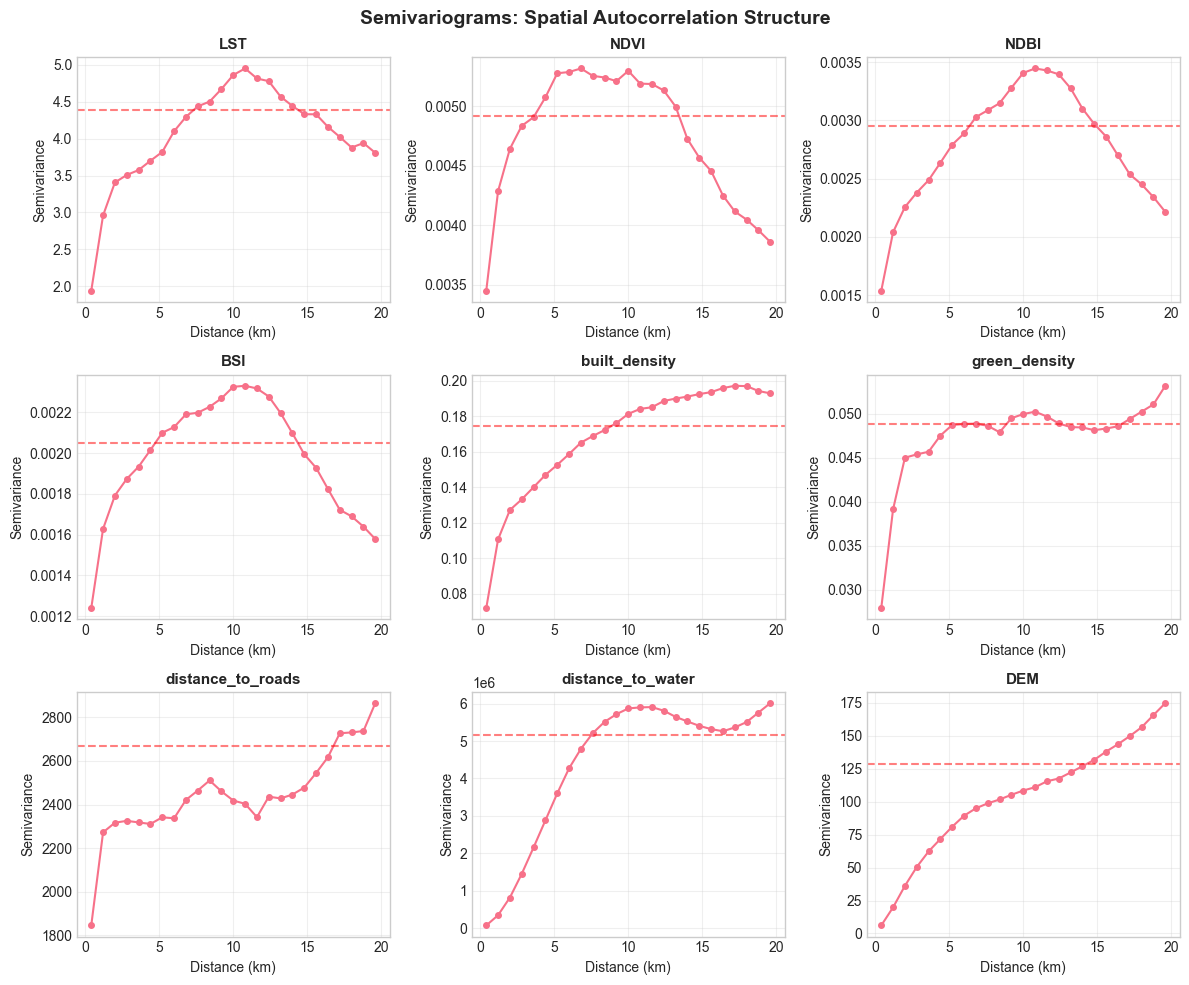


✓ Saved semivariogram plots


In [19]:
# --- 5.2: Semivariograms ---
key_vars = ['LST', 'NDVI', 'NDBI', 'BSI', 'built_density', 'green_density', 'distance_to_roads', 'distance_to_water', 'DEM']
max_dist = 20000  # 20 km max distance for variogram

# Compute variograms for key variables
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

correlation_ranges = {}

for i, var in enumerate(key_vars):
    ax = axes[i]
    
    bin_centers, semivar, counts = compute_semivariogram(df, var, n_bins=25, max_dist=max_dist)
    
    # Plot
    ax.plot(bin_centers/1000, semivar, 'o-', markersize=4, linewidth=1.5)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semivariance')
    ax.set_title(f'{var}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add horizontal line at sill (total variance)
    total_var = df[var].var()
    ax.axhline(y=total_var, color='red', linestyle='--', alpha=0.5, label='Total variance')
    
    # Estimate range (where semivariance reaches ~95% of sill)
    if not np.all(np.isnan(semivar)):
        threshold = 0.95 * total_var
        above_threshold = np.where(semivar > threshold)[0]
        if len(above_threshold) > 0:
            correlation_ranges[var] = bin_centers[above_threshold[0]] / 1000
        else:
            correlation_ranges[var] = None  # Did not reach sill

plt.suptitle('Semivariograms: Spatial Autocorrelation Structure', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['figures_dir'] / 'semivariograms.png', dpi=150, bbox_inches='tight')


print("\n" + "=" * 80)
print("SECTION 5: SPATIAL AUTOCORRELATION ANALYSIS")
print("=" * 80)

# --- 5.1: Moran's I (Global Spatial Autocorrelation) ---
print("\n--- Estimating Spatial Autocorrelation (Variogram Approach) ---")
print("(Full Moran's I is computationally expensive for large datasets)")

print("\nSemivariogram Summary (spatial autocorrelation indicator):")
print("  - Flat variogram = no spatial pattern")
print("  - Rising variogram = positive spatial autocorrelation")
print("  - Range where it flattens = spatial correlation distance")

# Print correlation ranges sorted from longest to shortest
print("\nAutocorrelation ranges (sorted longest to shortest):")
sorted_ranges = sorted(correlation_ranges.items(), key=lambda x: x[1] if x[1] is not None else float('inf'), reverse=True)
for var, r in sorted_ranges:
    if r is not None:
        print(f"  {var:.<25} Correlation range ≈ {r:.1f} km")
    else:
        print(f"  {var:.<25} Still spatially correlated beyond {max_dist/1000:.1f} km")


plt.show()
print(f"\n✓ Saved semivariogram plots")

NDVI, NDBI, BSI, LST, and distance_to_water all rise above the red line and then drop back. This means these variables have a large-scale spatial trend across the city (e.g., systematically higher NDBI in the core, lower on the outskirts). At intermediate distances (~7-10 km), we're comparing pixels from opposite ends of that gradient, so they're more different than random. At very large distances (12+ km), the curve drops because we start comparing outskirts-to-outskirts again, which are more similar.

DEM (~13.5 km) is the longest-range variable with a smooth regional tilt across the entire city. It just barely reaches the sill at the edge of our window. This makes physical sense cause topography changes slowly and continuously.

distance_to_roads never flattens because it has very low total variance (all pixels are within 0-660m of a road). The variogram is noisy and wandering because there just isn't much signal to structure spatially. We expected this, and further confirms that it's kind of a meaningless variable for our model, but we'll include it anyway to be consistent with Hoang et al.

**Our spatial CV block size = 7-8km**

The variables that matter most for our analysis (LST at 6.3 km, built_density at 6.9 km, distance_to_water at 7.5 km) all *converge around 7-8 km, so that's our target block size*. DEM at 13.5 km is an outlier, but it's a fixed geographic feature and it won't behave differently in new data, so it's less of a leakage concern. Ouagadougou is roughly 30 km across, so 7-8 km blocks gives us about 3-4 folds per axis, which is tight but workable for spatial CV.